# reference -> local -> global

since all the integrals in the discretization formulation are locally computed on the mesh elements, it is critical to have a convenient formulation of the lcoal basis functions on all the mesh elements.

## reference on [0, 1]
construct polynomial reference basis functions on [0,1]
$$ 
[A_{1}, A_{2}] = [0, 1]\,with\, nodes\,A_{i}\,\in [0, 1] \\
$$
Apply the following constraints
$$
\phi_{j}(A_{i}) = \delta_{i,j} = \left\{
    \begin{array}\\
        1 & \mbox{if } i = j \\
        0 & \mbox{else.}
    \end{array}
\right.
\\for \, i,j=1,2,3...N
$$

for example, the coeficients of the following quadratic reference basis functions can be solved with the above constraints.
$$
\phi_0(x)=x^{2} {a}_{2} + x {a}_{1} + {a}_{0}\\
\phi_1(x)=x^{2} {a}_{5} + x {a}_{4} + {a}_{3}\\
\phi_2(x)=x^{2} {a}_{8} + x {a}_{7} + {a}_{6}\\
$$

In [1]:
from sympy import *
import numpy as np

L = 2
numOfEq = L+1  #Nlb
x = symbols('x')
a = IndexedBase('a', shape=(numOfEq*numOfEq))

#level L polynomials
equationList = [sum(a[i*L + j + i]*x**j for j in range(L+1)) 
                for i in range(numOfEq)]

for i in range(numOfEq):
    #print('\phi_' +str(i) + '(x)=' + latex(equationList[i]) + '\\\\')
    display(equationList[i])

equationList[0].subs(x, 1/2)
h = 1/L
E = np.arange(0, 1+h, h)

#value at nodes
left = [equationList[i].subs(x, e) for e in E
              for i in range(numOfEq)]

#apply delta constraints
right= [int(i==j) for j in range(numOfEq)
       for i in range(numOfEq)]

expr=np.subtract(left, right)

#for i in range(expr.size):
#    display(expr[i])

param = []
for i in range(numOfEq*numOfEq):
    param.append(a[i])
    
sol = solve(expr, param)
print(sol)

#reference basis functions
for i in range(len(equationList)):
    display(equationList[i].subs(sol))

x**2*a[2] + x*a[1] + a[0]

x**2*a[5] + x*a[4] + a[3]

x**2*a[8] + x*a[7] + a[6]

{a[0]: 1.00000000000000, a[1]: -3.00000000000000, a[2]: 2.00000000000000, a[3]: 0.0, a[4]: 4.00000000000000, a[5]: -4.00000000000000, a[6]: 0.0, a[7]: -1.00000000000000, a[8]: 2.00000000000000}


2.0*x**2 - 3.0*x + 1.0

-4.0*x**2 + 4.0*x

2.0*x**2 - 1.0*x

## reference to local
Use affine mapping to construct the local basis functions on each cell [a,b] from the reference ones on [0,1].
$$
\ x \in [a, b] \,=>\, \ x-a \in [0, b-a]\,=>\, \frac{x-a}{b-a}\,\in [0,1] \\
convert\, to \,\phi_{i}(\frac{x-a}{b-a})=\phi_{i}(\frac{x-x_{n}}{h}), \, \ x \in [a,b] = [x_{n}, x_{n+1}]
$$

In [2]:
xn,h = symbols('xn h')
lbasis = [equationList[i].subs(sol).subs(x, (x-xn)/h) 
          for i in range(len(equationList))]
display(lbasis)

[1.0 - 3.0*(x - xn)/h + 2.0*(x - xn)**2/h**2,
 4.0*(x - xn)/h - 4.0*(x - xn)**2/h**2,
 -1.0*(x - xn)/h + 2.0*(x - xn)**2/h**2]

## Local to Global
We divide [a, b] into N cell/mesh elements.
$$H = \frac{b-a}{N}$$
$$x_{n} = a + (n-1)H \,(n=0, 1, 2, ...N)\, denotes\, mesh\, nodes$$
$$E_{n} = [x_{n}, x_{n+1}] \,(n=0,1,2,...N-1)\,denotes\, mesh\, elements.$$
We have already found the local basis functions on a cell En. Let Nlb denote the number of local finite element basis functions in one cell. Any function in En can be expressed by this set of local basis functions (in local finite element space).
$$
\S_{n}(E_{n}) = span\{\phi_{n1}, \phi_{n2}, \phi_{n3}...\phi_{n_{N_{lb}}}\}
$$
Within each cell En, we have Nlb finite element nodes to confine the Nlb local basis functions. 
$$
y_{n_{1}}, y_{n_{2}}, ..., y_{n_{N_{lb}}} \
where\, y_{n_{1}} = x_{n} \, and \,y_{n_{N_{lb}}} = x_{n+1}
$$
We have N cells, so the totally number of finite element nodes in [a, b] is:
$$N_{b} = N(N_{lb}-1) +1$$
the total number of global finite element is also:
$$N_{b}$$

With the above notations. At each finite element node yj (j=1, 2, 3...Nb), define the corresponding global linear basis function such that:

$$\Phi_{j}|E_{n} \in \S(E_{n})$$

$$\Phi_{j}(y_{i}) = \delta_{ij} = \left\{
    \begin{array}\\
        1 & \mbox{if } i = j \\
        0 & \mbox{else.}
    \end{array}
\right.
\\for \, i,j=1,2,3...N_{b}
$$

Once we found the global basis functions on [a, b]. Any function in [a, b] can be expressed by this set of global basis functions (in global finite element space).
$$
\S\S_{n}(E_{n}) = span\{\Phi_{j}\}_{j=1}^{N_{b}}
$$

Next, lets introduce a few groups of variables. <br>
We need a group of varibles to traversal the meshes or cells. <br>
Each cell or mesh can be futher divided into finite element grids. We need another group of variables to traversl the finite element grid nodes. <br>
Pb matrix is introduced to index the local basis functions in the nth cells


In [3]:
#number of cells
N = 5 
print('N=',N)
#[a, b]
start = 0
end = 1

#mesh cell size
H = (end - start)/N
print('H=',H)
#mesh cell bondary and index
P = np.arange(start, end + H, H)
print('P=',P)

T = np.arange(0, N, 1)
print('T=',T)

#number of finite element nodes or number of local basis functions in cell [xn, xn+1]
Nlb = numOfEq
print('Nlb=',Nlb)
#number of global finite element nodes or number of global basis functions in [start, end]
Nb = N * (Nlb - 1) + 1

print('Nb=',Nb)

#finite element grid size
hf = (end - start) / (Nb-1)

print('hf=',hf)
#finite element grid bondary and index
Pb = np.arange(start, end + hf, hf)
print('Pb=',Pb)
Tb = np.array([[i*(Nlb-1) + j for i in range(N)] for j in range(Nlb)])
#Tb[:,N-1] = 0
print('Tb=')
print(Tb)

N= 5
H= 0.2
P= [0.  0.2 0.4 0.6 0.8 1. ]
T= [0 1 2 3 4]
Nlb= 3
Nb= 11
hf= 0.1
Pb= [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Tb=
[[ 0  2  4  6  8]
 [ 1  3  5  7  9]
 [ 2  4  6  8 10]]


With the above variables, we can finally express global basis functions with the previous local basis functions as:

$$
\Phi_{j}|E_{n} = \left\{
    \begin{array}\\
        \phi_{n0} & \mbox{if } j = T_{b}[0, n] \\
        \phi_{n1} & \mbox{if } j = T_{b}[1, n] \\
        \phi_{n2} & \mbox{if } j = T_{b}[2, n] \\
        \phi_{n3} & \mbox{if } j = T_{b}[3, n] \\
        ...\\
        \phi_{n_{(N_{lb}-1)}} & \mbox{if } j = T_{b}[N_{lb}-1, n] \\
        0 & \mbox{else.}
    \end{array}
\right.
$$

for example, quadratic reference basis functions are:

$$
\Phi_{j}|E_{n} = \left\{
    \begin{array}\\
        \phi_{n0} & \mbox{if } j = T_{b}[0, n] = 2n \\
        \phi_{n1} & \mbox{if } j =  T_{b}[1, n] = 2n + 1 \\
        \phi_{n2} & \mbox{if } j =  T_{b}[2, n] = 2n + 2\\
        0 & \mbox{else.}
    \end{array}
\right.
$$

Thus, we have a funtion, given any n, j and x, we are able to find the corresponding expression with n and j, then apply the x value to get the output value. 

In [4]:
display(lbasis)


[1.0 - 3.0*(x - xn)/h + 2.0*(x - xn)**2/h**2,
 4.0*(x - xn)/h - 4.0*(x - xn)**2/h**2,
 -1.0*(x - xn)/h + 2.0*(x - xn)**2/h**2]

## Draw a graph of global basis function

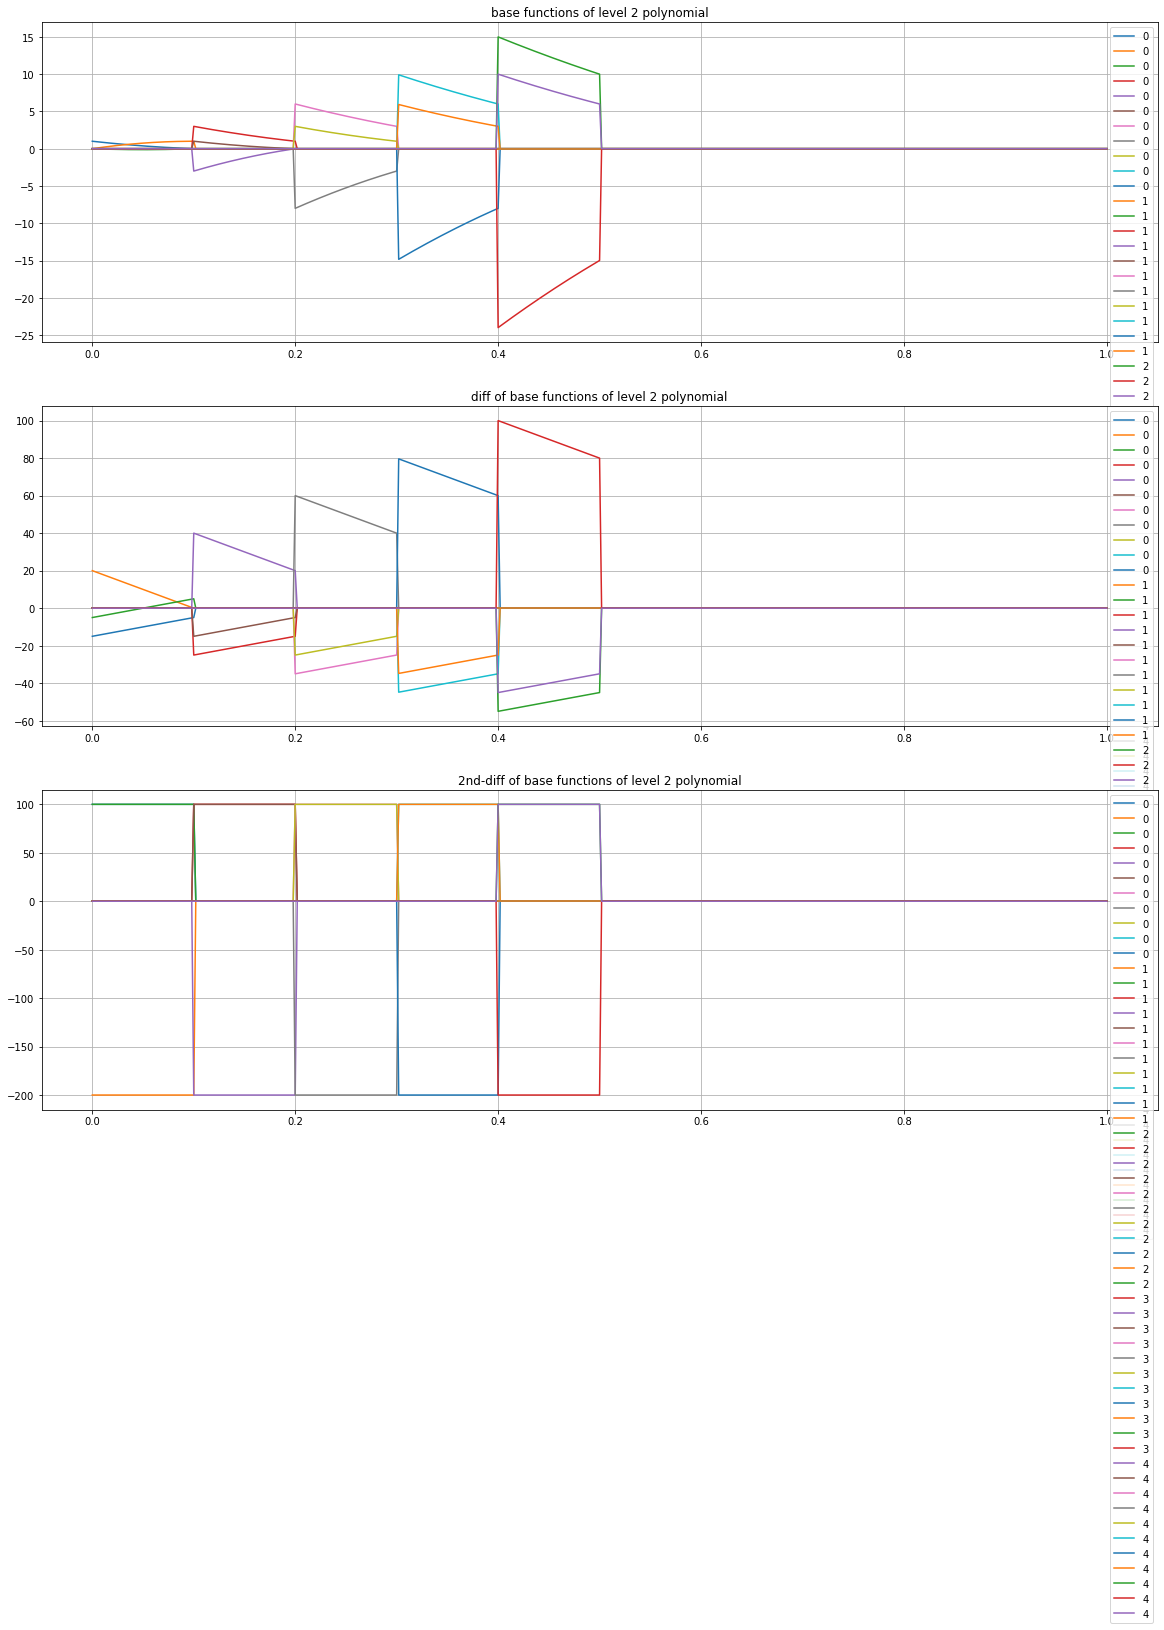

In [9]:
import matplotlib.pyplot as plt
def linearBase(j, n, dl=0):
    #print('j=',j,'n=',n)
    for nlb in range(Nlb):
        #print('nlb=',nlb,'Tb[nlb,n]=',Tb[nlb,n])
        if j == Tb[nlb,n]:
            phi = lbasis[nlb]
            return diff(phi.subs('h', H).subs('xn', P[n]), x, dl)
    return x - x

def phiarray(xarray, j, n, dl=0):
    l = xarray.copy()
    phi = linearBase(j, n, dl)
    #display(phi)
    for k in range(0, xarray.size):
        t = xarray[k]
        if t < Pb[n] or t > Pb[n+1]:
            l[k] =  0
        else:
            l[k] = phi.subs(x, xarray[k])
    return l
    
t=np.arange(start, end+hf/50, hf/50)

fig1 = plt.figure(1, figsize=(20, 20))
chart1 = fig1.add_subplot(311)
chart2 = fig1.add_subplot(312)
chart3 = fig1.add_subplot(313)
for n in range(N):
    for j in range(Nb):
        chart1.plot(t, phiarray(t, j, n), label=n)
chart1.grid()
chart1.legend()
chart1.title.set_text('base functions of level '+str(L)+' polynomial')

for n in range(N):
    for j in range(Nb):
        chart2.plot(t, phiarray(t, j, n, 1), label=n)
chart2.grid()
chart2.legend()
chart2.title.set_text('diff of base functions of level '+str(L)+' polynomial')

for n in range(N):
    for j in range(Nb):
        chart3.plot(t, phiarray(t, j, n, 2), label=n)
chart3.grid()
chart3.legend()
chart3.title.set_text('2nd-diff of base functions of level '+str(L)+' polynomial')
plt.show()